# Dyna-Q算法
## 简介

在强化学习中，模型通常指的是对环境的状态转移函数和奖励函数进行建模。根据是否具有环境的模型，强化学习方法分为两种：基于模型的强化学习（Model-based Reinforcement Learning）和无模型的强化学习（Model-free Reinforcement Learning）。在无模型的强化学习中，根据与环境交互采样到的数据直接进行策略提升或者价值估计。Sarsa和Q-learning算法便是两种无模型的强化学习方法，以及在之后的课程中介绍的方法也大多都是无模型的强化学习方法。在基于模型的强化学习中，模型可以是事先知道的，也可以是根据与环境交互采样到的数据学习得到的，然后用这个模型帮助策略提升或者价值估计。策略迭代和价值迭代是基于模型的强化学习方法，在这两种算法中环境模型是事先已知的。而本节课程中即将介绍的Dyna-Q算法也是非常基础的基于模型的强化学习方法，它的环境模型是通过估计得到。

强化学习算法的一个重要的评价指标是算法收敛后的策略在初始状态的期望回报，而另一个同样重要的评价指标是样本复杂度，即算法达到收敛结果需要在环境中采样的样本数量。而基于环境的强化学习方法由于具有一个环境模型，可以额外和模型进行交互，对真实环境中样本的需求量就会减少，所以通常会比无模型的强化学习方法具有更低的样本复杂度。另一方面，环境模型可能并不准确，不能完全代替真实环境，所以基于环境的强化学习方法收敛后策略的期望回报可能不如无模型强化学习方法。

<img src="https://staticcdn.boyuai.com/user-assets/358/CM2gRtzqJKbAhh9MXKqsmn/qh3ccm4a0l.png!png" width = "400" height = "400" align=center />
 
<center>基于模型的强化学习方法与无模型的强化学习 </center>

## Dyna-Q
Dyna-Q算法是一个经典的基于模型的强化学习算法。Dyna-Q使用一种叫做Q-planning的方法来用模型生成一些模拟数据，然后用模拟数据和真实数据一起改进策略。Q-planning每次选取一个曾经访问过的状态$s$，采取一个曾经在该状态下执行过的动作$a$，通过模型得到转移后的状态$s'$以及奖励$r$，并根据这个模拟数据用Q-learning的更新方式来更新动作价值函数。下面我们来看一下Dyna-Q的具体算法。

- 初始化$Q(s,a)$，初始化模型$M(s,a)$
- 不断进行$N$次如下循环(每个循环是一条序列)：
	- 得到初始状态$s$
	- 不断进行如下循环直至终止状态（每个循环是序列中的一步）:
		- 用$\epsilon$-greedy策略根据$Q$选择当前状态$s$下的动作$a$
		- 得到环境反馈的$r, s'$
		- $Q(s,a) \leftarrow Q(s,a) + \alpha[r + \gamma \max_{a'} Q(s',a')-Q(s,a)]$
		- $M(s,a) \leftarrow r, s'$
		- 重复以下循环$n$次（每个循环是一次Q-planning）：
			- 随机选择一个曾经访问过的状态$s_m$ 
			- 采取一个曾经在状态$s_m$下执行过的动作$a_m$
			- $r_m,s'_m \leftarrow M(s_m, a_m)$
			- $Q(s_m,a_m) \leftarrow Q(s_m,a_m) + \alpha[r_m + \gamma \max_{a'} Q(s'_m,a')-Q(s_m,a_m)]$
		- $s\leftarrow s'$

我们看到，在每次与环境进行交互做一次Q-learning之后，Dyna-Q会做多次Q-planning。其中Q-planning的次数$n$是一个事先可以选择的超参数，当其为0时就是普通的Q-learning。

## Dyna-Q代码实践
我们之前在Cliff Walking环境中运行过Q-learning算法，我们现在也在这个环境中尝试Dyna-Q，以方便比较。 首先仍是Cliff Walking的环境代码，这和上一章节一模一样。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
import time

class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow       
        self.ncol = ncol
        self.x = 0 # 记录当前智能体位置的横坐标
        self.y = self.nrow - 1 # 记录当前智能体位置的纵坐标

    def step(self, action): # 外部调用这个函数来让当前位置改变
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]] # 4 种动作, 0:上, 1:下, 2:左, 3:右。原点(0,0)定义在左上角
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0: # 下一个位置在悬崖或者终点
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self): # 回归初始状态，起点在左上角
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

然后我们来看一下Dyna-Q的主要代码。主要在Q-learning的代码上进行简单修改。最主要的部分是加入了环境模型model，我们用一个字典表示，每次在真实环境中新收集到数据，把它加到字典里。根据字典的性质，若该数据本身存在字典中，便不会再一次添加。在Dyna-Q的更新中，进行完Q-learning后，会立即进行Q-planning。

In [2]:
class DynaQ:
    """ Dyna-Q算法 """
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_planning, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action]) # 初始化Q(s,a)表格
        self.n_action = n_action # 动作个数
        self.alpha = alpha # 学习率
        self.gamma = gamma # 折扣因子
        self.epsilon = epsilon # epsilon-greedy策略中的参数
        
        self.n_planning = n_planning
        self.model = dict()
        
    def take_action(self, state): #选取下一步的操作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def q_learning(self, s0, a0, r, s1):
        td_error = r + self.gamma * self.Q_table[s1].max() - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error
            
    def update(self, s0, a0, r, s1):
        self.q_learning(s0, a0, r, s1)
        self.model[(s0, a0)] = r, s1 # 将数据添加到模型中
        for _ in range(self.n_planning): # Q-planning循环
            (s, a), (r, s_) = random.choice(list(self.model.items())) #随机选择曾经遇到过的状态动作对
            self.q_learning(s, a, r, s_) 

下面是Dyna-Q算法在Cliff Walking环境中的训练函数，它的输入参数是Q-planning的步数。

In [3]:
def DynaQ_CliffWalking(n_planning):
    ncol = 12
    nrow = 4
    env = CliffWalkingEnv(ncol, nrow)
    epsilon = 0.01
    alpha = 0.1
    gamma = 0.9
    agent = DynaQ(ncol, nrow, epsilon, alpha, gamma, n_planning)
    num_episodes = 300 # 智能体在环境中运行多少条序列

    return_list = [] # 记录每一条序列的回报
    for i in range(10): # 显示10个进度条
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar: # tqdm的进度条功能
            for i_episode in range(int(num_episodes/10)): # 每个进度条的序列数
                episode_return = 0
                state = env.reset()
                done = False
                while not done: 
                    action = agent.take_action(state)
                    next_state, reward, done = env.step(action)
                    episode_return += reward # 这里回报的计算不进行折扣因子衰减
                    agent.update(state, action, reward, next_state)
                    state = next_state
                return_list.append(episode_return) 
                if (i_episode+1) % 10 == 0: # 每10条序列打印一下这10条序列的平均回报
                    pbar.set_postfix({'episode': '%d' % (num_episodes / 10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list

可视化结果，通过调整参数，我们可以观察Q-planning步数对结果的影响。若Q-planning步数为0，则退化到Q-learning。

Q-planning步数为：0


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 1230.77it/s, episode=300, return=-16.500]


Q-planning步数为：2


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 960.44it/s, episode=300, return=-13.500] 


Q-planning步数为：20


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 247.61it/s, episode=300, return=-13.400]


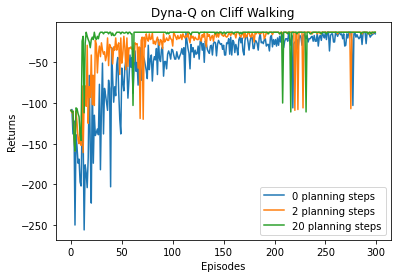

In [4]:
np.random.seed(0)
random.seed(0)
n_planning_list = [0, 2, 20]
for n_planning in n_planning_list:
    print('Q-planning步数为：%d' % n_planning)
    time.sleep(0.5)
    return_list = DynaQ_CliffWalking(n_planning)
    episodes_list = list(range(len(return_list)))
    plt.plot(episodes_list, return_list, label=str(n_planning) + ' planning steps')
plt.legend()
plt.xlabel('Episodes')   
plt.ylabel('Returns')  
plt.title('Dyna-Q on {}'.format('Cliff Walking'))  
plt.show()

可以明显地看出随着Q-planning步数的增多，Dyna-Q算法的收敛速度也随之变快。

## 总结
我们学习了一个经典的基于模型的强化学习算法Dyna-Q，并且通过调整在Cliff Walking下的Q-planning步数，直观地看到了Q-planning步数对于收敛速度的影响。虽然我们发现基于模型的强化学习方法Dyna-Q在以上环境中获得了很好的效果，但这些环境比较简单，模型可以直接通过统计得到。如果环境比较复杂，例如状态是连续的，不再是离散的，如何学习一个比较准确的模型就变成了一个非常重大的挑战，这直接影响到基于模型的强化学习方法能否应用于这些环境获得比无模型的强化学习更好的效果。